# Clean light curves

The goals of this notebook are to: 

* Get light curves for analysis with STSP
 * read light curves from MAST
 * normalize each quarter of data by a 2nd order polynomial
* Measure the HAT-P-11 transit depth
 * identify transits that have the fewest/weakest starspot crossings
 * fit transit model to those most "spotless" transits
 * get a best depth measurement to use for STSP

### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

In [50]:
#%load_ext autoreload
#%autoreload 2

import os
from glob import glob
import datacleaner
reload(datacleaner)
from datacleaner import LightCurve
import numpy as np

path_to_fits_files = '/local/tmp/hat11/010748390/'

# Retrieve long and short cadence data
long_cadence_paths = glob(os.path.join(path_to_fits_files, '*llc.fits'))
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

long_lc = LightCurve.from_raw_fits(long_cadence_paths, name='raw_long')
short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short')

data_path = '/astro/users/bmmorris/git/hat-11/lightcurves'
long_lc.save_to(data_path)
short_lc.save_to(data_path)

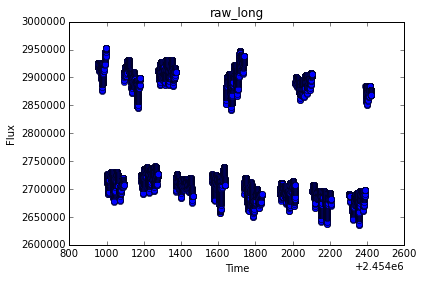

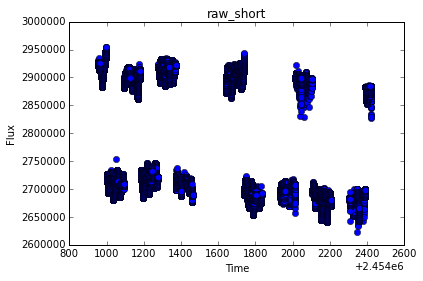

In [2]:
%matplotlib inline
long_lc.plot()
short_lc.plot()

### Normalize by quarter

For each quarter, fit a $O$(2) polynomial and divide the light curve by that polynomial. Save to `normalized_long` and `normalized_short`

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2

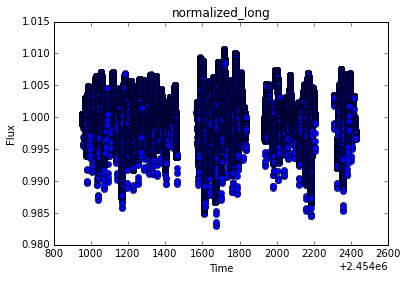

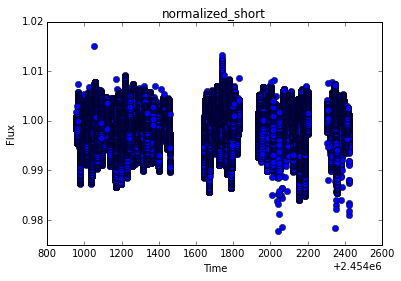

In [51]:
# Fit 2nd order polynomial to each quarter, divide to normalize
long_lc.normalize_each_quarter(rename='normalized_long')
short_lc.normalize_each_quarter(rename='normalized_short')

# Plot results, save
long_lc.plot()
short_lc.plot()

long_lc.save_to(data_path)
short_lc.save_to(data_path)

### Break out individual transits

Separate light curve into individual transits by masking out the out-of-transit portions of the light curve and separating the big `LightCurve` object into lots of little `TransitLightCurve` objects.

Then fit the out-of-transit portions of each transti for a linear baseline trend, and divide it out.

In [52]:
from datacleaner import LightCurve
short_transits = LightCurve(name='transits_short', **short_lc.mask_out_of_transit())
short_transits.save_to(data_path, overwrite=True)
transits = short_transits.get_transit_light_curves()
for transit in transits:
    transit.remove_linear_baseline()

### Identify "spotless" transits

* do rough model fit to each transit with `scipy.optimize.fmin` including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model
 
**Hypothesis**: $\chi^2$ can be used as a proxy for inverse starspot-importance in each transit. Transits with low $\chi^2$ are well-described by a simple transit model, which implies they have few spot crossings. 

In [53]:
# Warning: this step fits each transit in the short cadence data and is slow (~2 min)
import os
chi2_file_path = 'chi2.npy'
if not os.path.exists(chi2_file_path):
    chi2 = np.array([transit.fiducial_transit_fit()[1] for transit in transits])
    np.save(chi2_file_path, chi2)
else:
    chi2 = np.load(chi2_file_path)

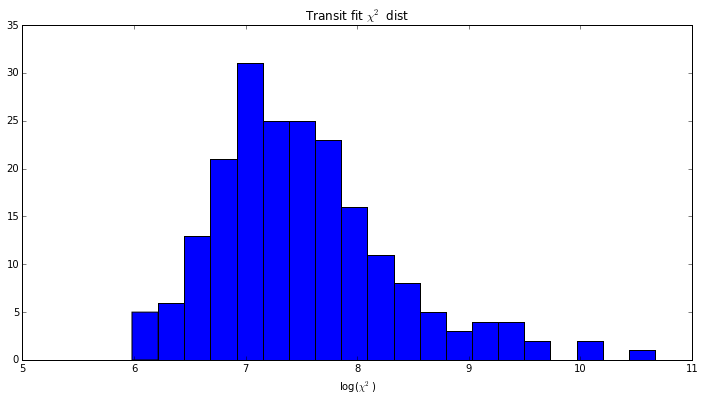

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

The distribution of $\chi^2$ shows that there's a long tail of poor fits to the data, and a handful of very good fits. The handful of very good fits all have $\log{\chi^2} < 6.5$. Any higher than 6.5 and there are readily visible spot-crossings in the transit. Now filter out only these transits with $\log{\chi^2} < 6.5$ for detailed transit analysis.

### Combine "spotless" light curves, fit model

In [55]:
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit()
    depths.append(p[1])
    chi2.append(chi)

# spotless transits: 3


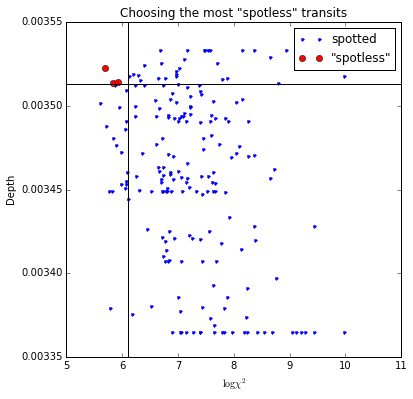

In [68]:
chi2_threshold = 6.1
depth_threshold = 0.003513
reload(datacleaner)
from datacleaner import concatenate_transit_light_curves
spotless_transit_inds = (np.log(chi2) < chi2_threshold) * (np.array(depths) > depth_threshold)
spotless_transits = concatenate_transit_light_curves([transit for i, transit in enumerate(transits) 
                                                      if spotless_transit_inds[i]], name='spotless_transits')
spotless_transits.save_to(data_path, overwrite=True)

print('# spotless transits: {}'.format(np.count_nonzero(spotless_transit_inds)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.', label='spotted')
ax.plot(np.log(chi2)[spotless_transit_inds], 
        np.array(depths)[spotless_transit_inds], 'ro', label='"spotless"')

ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.legend(loc='upper right')
ax.set_ylim([0.00335, 0.00355])
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth', 
       title='Choosing the most "spotless" transits');

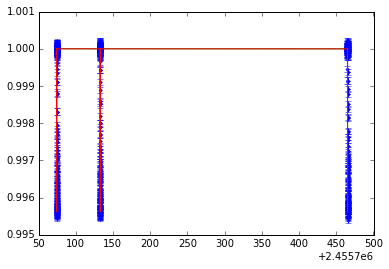

In [69]:
leastsq_fit_params, chi2_spotless = spotless_transits.fiducial_transit_fit(plots=True)

In [70]:
each_spotless_transit = spotless_transits.get_transit_light_curves()
print("Mean times of three 'spotless' transits: {0}"
      .format([t.times.jd.mean() for t in each_spotless_transit]))

Mean times of three 'spotless' transits: [2455774.0759595903, 2455832.729624175, 2456165.1000150847]


### Use `emcee` to get PDFs for interesting transit parameters

Here I'm fitting for: $t_0$, depth, duration, impact parameter and Kipping's efficient two-parameter limb-darkening terms $q_1$, $q_2$.

In [78]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
[t0, depth, dur, b] = leastsq_fit_params
[q1, q2] = [0.518, 0.426] # Claret -> Kipping
p0 = [t0, depth, dur, b, q1, q2]
n_steps = 1500
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                             n_steps)

accept frac = 0.428146666667


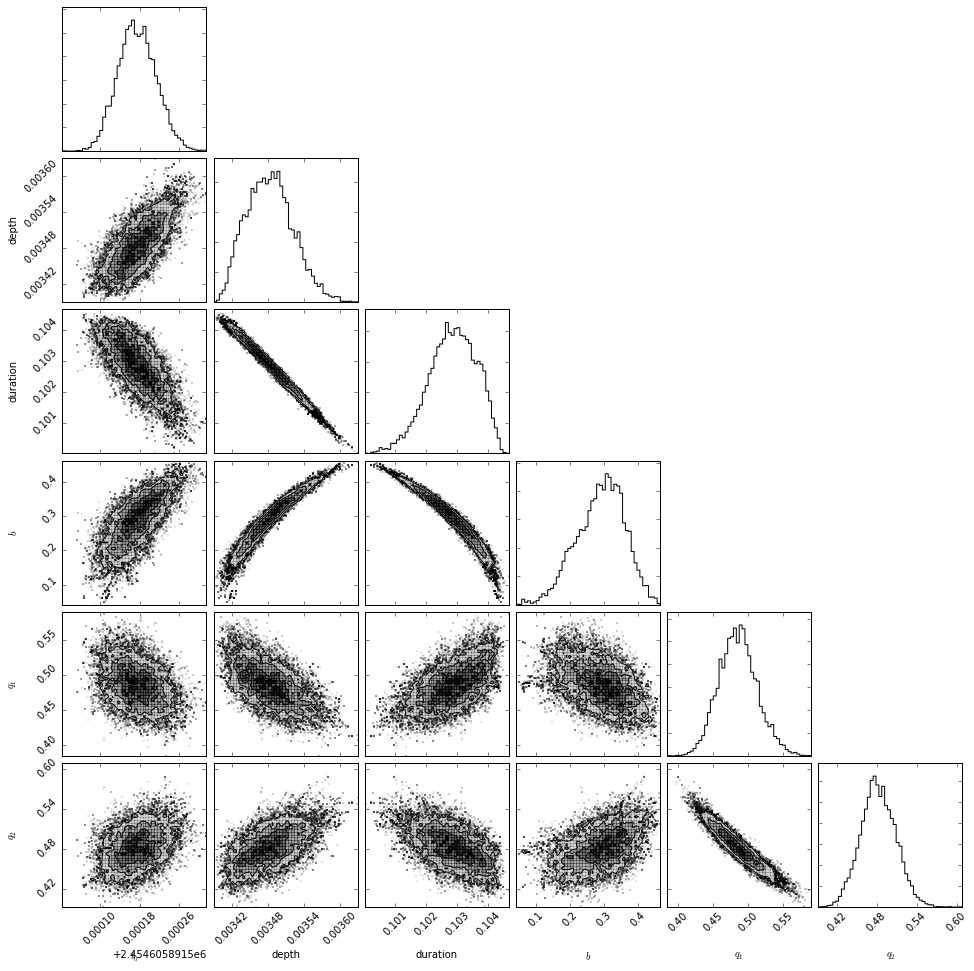

In [79]:
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle
print("accept frac = {}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples[:, :])

In [80]:
import cleanfit
reload(cleanfit)
from cleanfit import print_emcee_results
from IPython.display import display_latex, Latex

#print_emcee_results(samples)
Latex(print_emcee_results(samples))

<IPython.core.display.Latex object>

### Fit for ephemeris using best-fit parameters from "spotless" fits

In [98]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee_ephemeris, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
depth, dur, b, q1, q2 = np.median(samples[:, 1:], axis=0)

p0 = [np.median(samples[:, 0]), 4.8878018]
bestfit_transit_params = [depth, dur, b, q1, q2]

scale_the_errors_by_a_factor_of = 1.0
# normalized_short_transits = concatenate_transit_light_curves(transits, 
#                                                              name='normalized short cadence transits')

low_chi2 = (np.log(chi2) < chi2_threshold)
low_chi2_transits = [transit for i, transit in enumerate(transits) 
                     if low_chi2[i]]
low_chi2_transits_all = concatenate_transit_light_curves(low_chi2_transits, name='low_chi2_transits')
low_chi2_transits_two = concatenate_transit_light_curves([low_chi2_transits[0], 
                                                          low_chi2_transits[-1]])

n_steps = 1800
sample_factor = 1
samples_eph, sampler_eph = run_emcee_ephemeris(p0, low_chi2_transits_two.times.jd[::sample_factor], 
                                               low_chi2_transits_two.fluxes[::sample_factor], 
                                               low_chi2_transits_two.errors[::sample_factor], 
                                               n_steps, bestfit_transit_params, 
                                               n_walkers=20)

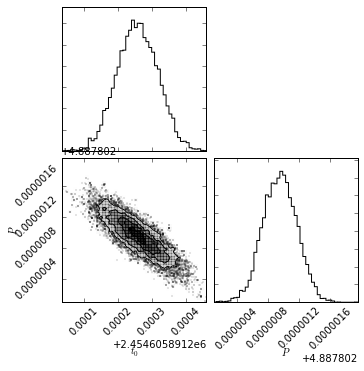

In [99]:
plot_triangle(samples_eph)

In [100]:
for i, p in enumerate(['mid-transit time', 'period']):
    mid, minus, plus = np.percentile(samples_eph[:,i], [50, 16, 84])
    print("{3}: {0:.8f} +{1:.8f} -{2:.8f}".format(mid, plus-mid, mid-minus, p))

mid-transit time: 2454605.89145823 +0.00006153 -0.00005970
period: 4.88780296 +0.00000022 -0.00000022


Now with new period measurement, fit the spotless transits again. These are the final posteriors.

In [106]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

p0 = np.median(samples[:, :], axis=0) # [t0, depth, dur, b, q1, q2]
n_steps = 2000
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples_refined, sampler_refined = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                                             n_steps, P = np.percentile(samples_eph[:,1], 50),
                                             n_walkers=70)

accept frac = 0.396621428571


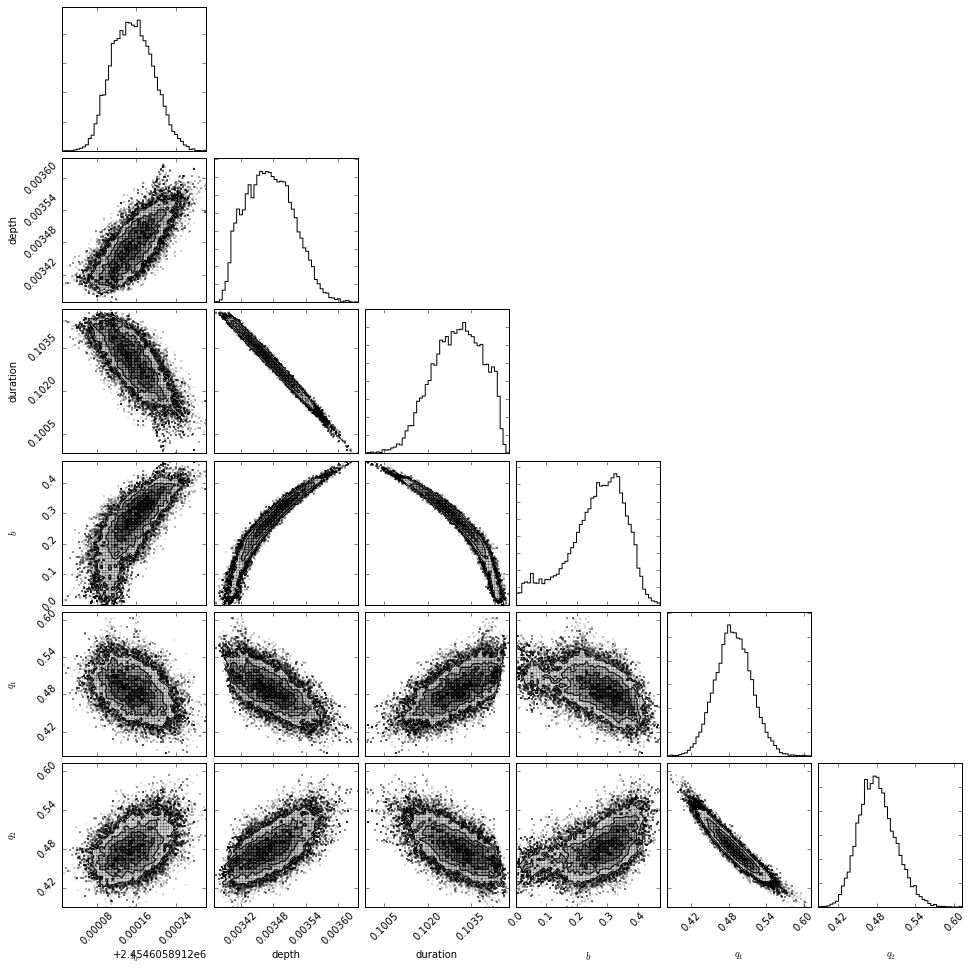

In [107]:
print("accept frac = {}".format(np.mean(sampler_refined.acceptance_fraction)))
plot_triangle(samples_refined[:, :])

In [110]:
Latex(print_emcee_results(samples_refined))

<IPython.core.display.Latex object>

In [173]:
mid, minus, plus = np.percentile(samples_eph[:,1], [50, 16, 84])
best_fit_period = mid
Latex("$P: {{{0:.8f}}}^{{+{1:.8f}}}_{{-{2:.8f}}}$"
      .format(mid, plus-mid, mid-minus, p))

<IPython.core.display.Latex object>

In [179]:
from datacleaner import T14b2aRsi

dur_refined, b_refined = np.median(samples_refined[:, [2,3]], axis=0)
a_over_Rs, inclination = T14b2aRsi(best_fit_period, dur_refined, b_refined)
print("Inclination: {0}".format(inclination))

def rho_star(samples, P=best_fit_period):
    import astropy.units as u
    from astropy.constants import G
    """Calculate stellar density from MCMC chain samples"""
    T14 = samples[:,2]
    b = samples[:,3]
    aRs, i_deg = T14b2aRsi(P, T14, b)
    rho_s = 3*np.pi/(G*(P*u.day)**2) * aRs**3
    rho_s = rho_s.to(u.g/u.cm**3)
    
    mid, minus, plus = np.percentile(rho_s, [50, 16, 84])
    lower = mid - minus
    upper = plus - mid
    
    return mid, lower, upper

rho = rho_star(samples_refined)
print("Mean stellar density: {0:.2f} +{1:.2f} -{2:.2f} g cm^-3".format(*rho))
print("Note, this is larger than the asteroseismic result "
      "from Christensen-Dalsgaard+2010 of 2.5127 g/cm^3")

Inclination: 88.9027452976
Mean stellar density: 2.41 +0.12 -0.13 g cm^-3
Note, this is larger than the asteroseismic result from Christensen-Dalsgaard+2010 of 2.5127 g/cm^3


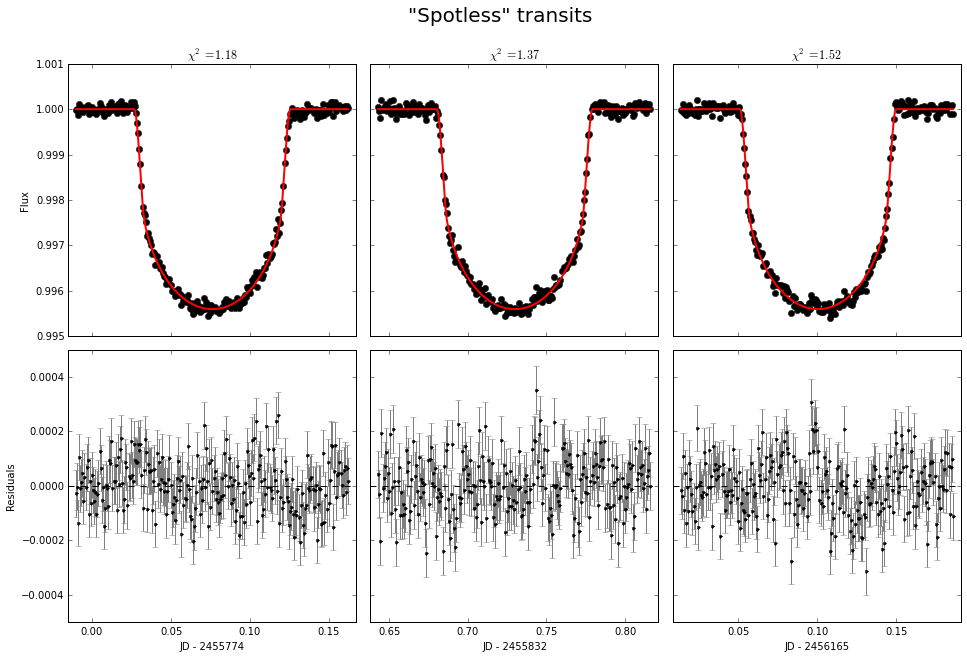

In [208]:
best_fit_results = np.median(samples_refined, axis=0)
from cleanfit import generate_model_lc_short

dtimes = np.diff(transit_lc.times.jd)
t_splits = np.argwhere(dtimes > 10*np.median(dtimes)).T[0] + 1
t_splits = np.concatenate([[0], t_splits, [len(dtimes)]])

fig, ax = plt.subplots(2, 3, figsize=(16, 10), sharex='col', sharey='row')

for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    mean_jd_int = int(np.mean(transit_lc.times.jd[start:stop]))
    
    transitmodel = generate_model_lc_short(transit_lc.times.jd[start:stop], 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))
    
    ax[0, i].plot(transit_lc.times.jd[start:stop] - mean_jd_int, 
                  transit_lc.fluxes[start:stop], 'ko')

    ax[0, i].plot(transit_lc.times.jd[start:stop] - mean_jd_int, transitmodel,
                  'r', lw=2)

    ax[1, i].errorbar(transit_lc.times.jd[start:stop] - mean_jd_int, 
                      transit_lc.fluxes[start:stop] - transitmodel, 
                      transit_lc.errors[start:stop],
                      fmt='.', color='k', ecolor='gray')
    
    ax[1, i].axhline(0, ls='--', color='k')
    ax[1, i].set_xlabel("JD - {0}".format(mean_jd_int))

    transit_chi2 = (np.sum((transit_lc.fluxes[start:stop] - transitmodel)**2 / 
                           transit_lc.errors[start:stop]**2) /
                    (len(transit_lc.fluxes[start:stop]) - len(best_fit_results)))
    ax[0, i].set_title("$\chi^2 = {0:.2f}$".format(transit_chi2))
    
    ax[0, i].set_xlim([transit_lc.times.jd[start:stop].min() - mean_jd_int - 0.005, 
                       transit_lc.times.jd[start:stop].max() - mean_jd_int + 0.005])
    
ax[0, 0].set_ylabel('Flux')
ax[1, 0].set_ylabel('Residuals')
spacing = 0.05
fig.subplots_adjust(hspace=spacing, wspace=spacing)
fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
fig.savefig("../plots/splotless_transits.png", bbox_inches='tight')
plt.show()

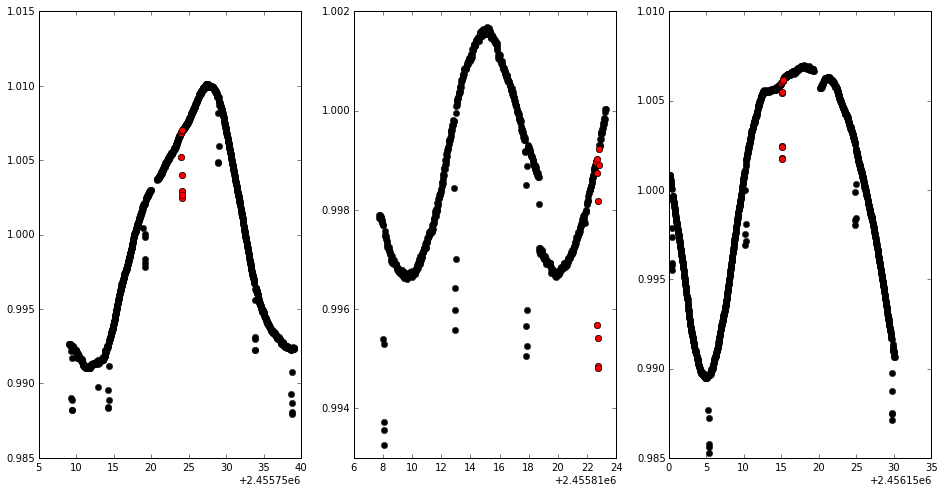

In [167]:
long_cadence = LightCurve.from_dir('../lightcurves/normalized_long')

fig, ax = plt.subplots(1, 3, figsize=(16, 7))
for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]
    mean_jd = np.mean(transit_lc.times.jd[start:stop])
    
    in_broad_window = np.abs(long_cadence.times.jd - mean_jd) < 15
    in_narrow_window = np.abs(long_cadence.times.jd - mean_jd) < 0.1
    
    ax[i].plot(long_cadence.times.jd[in_broad_window], 
               long_cadence.fluxes[in_broad_window], 'ko')
    ax[i].plot(long_cadence.times.jd[in_narrow_window], 
               long_cadence.fluxes[in_narrow_window], 'ro')

plt.show()

### Converting Kipping 2 limb darkening parameters into four-parameter law

$$ \text{Quadratic: } I(\mu)/I(1) = 1−a(1−\mu)−b(1−\mu)^2$$

$$ \text{"Nonlinear": } I(\mu)/I(1) = 1−a(1−\mu^{1/2})−b(1−\mu)-c(1-\mu^{3/2}) - d(1-\mu^2)$$

We can't convert directly from Quadratic to nonlinear, but here I'll try fitting a nonlinear model to our quadratic solution. 

Best nonlinear limb-darkening parameters: 
a, b, c, d = 
0.000, 0.727, 0.000, -0.029


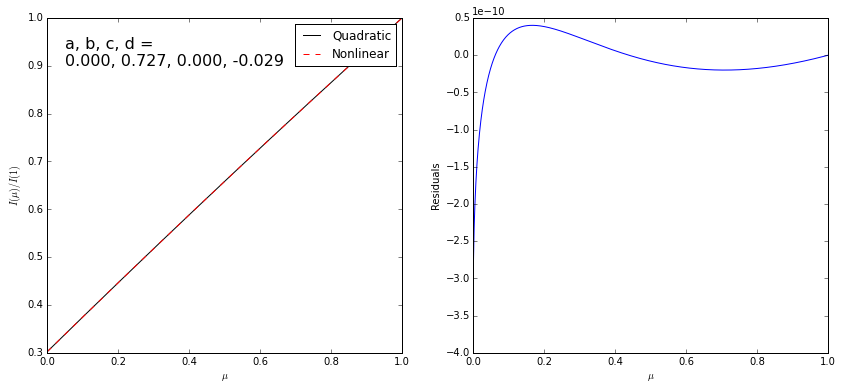

In [205]:
mu = np.linspace(0, 1, 1000)

def quadratic_law(p, mu):
    u1, u2 = p
    return 1 - u1*(1-mu) - u2*(1-mu)**2

def nonlinear_law(p, mu):
    a, b, c, d = p
    return 1 - a*(1-mu**0.5) - b*(1-mu) - c*(1-mu**1.5) - d*(1-mu**2)

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

best_fit_quadratic = kipping_to_quadratic(np.median(samples_refined[:, -2:], axis=0))
best_quadratic_model = quadratic_law(best_fit_quadratic, mu)

from scipy import optimize

initp = [0, 0.6, 0, 0]
bestp = optimize.leastsq(lambda p, mu: best_quadratic_model - nonlinear_law(p, mu), 
                         initp, args=(mu))[0]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(mu, best_quadratic_model, color='k', label='Quadratic')
ax[0].plot(mu, nonlinear_law(bestp, mu), ls='--', color='r', label='Nonlinear')
ax[1].plot(mu, nonlinear_law(bestp, mu) - best_quadratic_model)

ax[0].legend()
ax[0].set(xlabel=r'$\mu$', ylabel=r'$I(\mu)/I(1)$')
ax[1].set(xlabel=r'$\mu$', ylabel='Residuals')

ax[0].text(0.05, 0.9, 
           'a, b, c, d = \n{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}'
           .format(*bestp), fontsize=16)
print("Best nonlinear limb-darkening parameters: \n"
      "a, b, c, d = \n{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}"
           .format(*bestp))
plt.show()